# Part 6 - Advanced Regression Techniques
In this notebook we will investigate some popular advanced regression techniques:  
* XGBoost
* Random Forest
* MultiLayer Perceptron (Neural Network)
  
We will use the exact same dataset and features as before and compare the results with our Linear Regressor.  
You will be happy to learn that the same procedure for training a Linear Regressor applies to nearly all other regression models!

In [40]:
from os import path
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
%matplotlib inline

## Let's load the data and remind ourselves of the contents

In [41]:
data_dir = './data'
df = pd.read_csv(path.join(data_dir, 'data_clean_engineered.csv'))
df.head()

,bath,bed,sqft,price,property_type_apartment,property_type_auction,property_type_coming,property_type_condo,property_type_coop,property_type_house,...,postal_code_94121,postal_code_94122,postal_code_94123,postal_code_94124,postal_code_94127,postal_code_94131,postal_code_94132,postal_code_94133,postal_code_94134,postal_code_94158
0,1.000000,1.000000,920.0,1195000.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.000000,2.000000,1238.0,1425000.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.000000,2.000000,1925.0,1600000.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.040583,2.099728,6882.0,998000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.000000,1.000000,580.0,678888.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
features = [feature for feature in df.columns if feature != 'price']
X = df[features]
y = df['price']
X_np = X.values
y_np = y.values.reshape((len(df), 1))

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=123) # split 70% train, 30% validation

In [44]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X) # predict y values from input X
    mse = mean_squared_error(y_true=y, y_pred=y_pred)
    print("Mean Squared Error: {}".format(mse))
    print("Accuracy: {}%".format(model.score(X, y)*100.0))

## XGBoost - Extreme Gradient Boosting  
[paper](http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf)  

XGBoost is a popular machine learning algorithm applied to tabulated data. If tuned properly, it can perform very well across many different datasets and we can even visualize the "feature importance" and get an idea of how the model generates its prediction.  
  
High accuracy *AND* intuitive results? Sign me up!  
  
  
Before proceeding, let's watch a few quick clips to learn more about **Boosting**

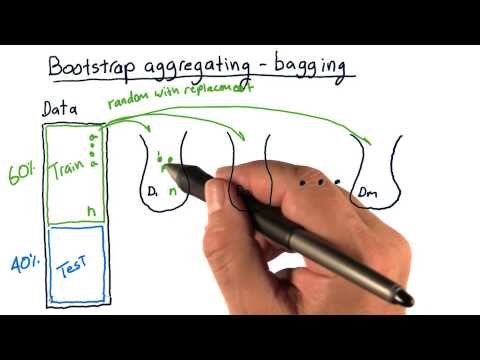

In [45]:
from IPython.display import YouTubeVideo
YouTubeVideo(id='2Mg8QD0F1dQ')

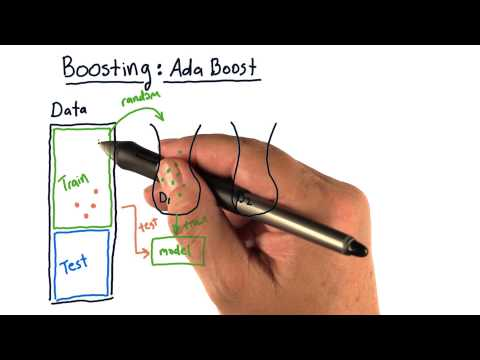

In [46]:
YouTubeVideo(id='GM3CDQfQ4sw')

### If time permits: Gradient Boosting whiteboard example
http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/

Import the xgboost library and fit our regressor same as before

In [47]:
from xgboost import XGBRegressor
xgb_regressor = XGBRegressor()
xgb_model = xgb_regressor.fit(X_train, y_train)
evaluate_model(xgb_model, X_val, y_val)

Mean Squared Error: 312744971143.1122
Accuracy: 74.95945453224141%


### Visualize the Feature Importance that XGBRegressor has assigned

In [48]:
# create a dataframe of feature importances
feature_importances = pd.DataFrame(columns=X.columns)
feature_importances.loc[0] = xgb_model.feature_importances_
# melt columns so we can easily sort and visualize
df_melt = pd.melt(feature_importances, value_vars=X.columns).sort_values(by='value', ascending=False)
df_melt

,variable,value
2,sqft,0.372457
0,bath,0.153365
1,bed,0.054773
15,postal_code_94105,0.042254
21,postal_code_94112,0.031299
35,postal_code_94134,0.029734
30,postal_code_94124,0.025039
24,postal_code_94116,0.023474
9,property_type_lot,0.021909
29,postal_code_94123,0.020344


### Retrain on entire dataset and save model to disk

In [49]:
model_dir = './models'

In [50]:
xgb_model = xgb_regressor.fit(X, y)
with open(path.join(model_dir, 'xgb.pkl'), 'wb') as f:
    pickle.dump(xgb_model, f)

# Let's train a few different regressors

## Random Forest  
https://en.wikipedia.org/wiki/Random_forest

In [51]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor()
rf_model = rf_regressor.fit(X_train, y_train)
evaluate_model(rf_model, X_val, y_val)
rf_model = rf_regressor.fit(X, y)
with open(path.join('random_forest.pkl'), 'wb') as f:
    pickle.dump(rf_model, f)

Mean Squared Error: 353217067202.15643
Accuracy: 71.7189760112351%


## MultiLayer Perceptron
https://en.wikipedia.org/wiki/Multilayer_perceptron

In [52]:
from sklearn.neural_network import MLPRegressor
mlp_regressor = MLPRegressor(max_iter=20000, random_state=123, solver='lbfgs')
mlp_model = mlp_regressor.fit(X_train, y_train)
evaluate_model(mlp_model, X_val, y_val)
mlp_model = mlp_regressor.fit(X, y)
with open(path.join(model_dir, 'mlp.pkl'), 'wb') as f:
    pickle.dump(mlp_model, f)

Mean Squared Error: 528208430561.21594
Accuracy: 57.70794595488786%


## Kernel Ridge Regression

In [53]:
from sklearn.kernel_ridge import KernelRidge
krr_regressor = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5, )
krr_model = krr_regressor.fit(X_train, y_train)
evaluate_model(krr_model, X_val, y_val)
krr_model = krr_regressor.fit(X, y)
with open(path.join(model_dir, 'krr.pkl'), 'wb') as f:
    pickle.dump(krr_model, f)

Mean Squared Error: 316946430096.5449
Accuracy: 74.62305640065895%


## ElasticNet

In [54]:
from sklearn.linear_model import ElasticNet
eln_regressor = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3, max_iter=1000)
eln_model = eln_regressor.fit(X_train, y_train)
evaluate_model(eln_model, X_val, y_val)
eln_model = eln_regressor.fit(X, y)
with open(path.join(model_dir, 'eln.pkl'), 'wb') as f:
    pickle.dump(eln_model, f)

Mean Squared Error: 396472222683.61145
Accuracy: 68.25566632606449%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
